In [1]:
##################################################
# THIS CELL APPLIES ONLY IF YOU RUN THE NOTEBOOK
#             WITHIN GOOGLE COLAB
# PLEASE press "Copy to Google Drive" button on Colab button bar
##################################################
# You need to perform these steps only 
# the first time you connect to COLAB
###################################
# except the "cd %APET" MUST BE RUN every time!
###################################
# REMOVE THE # FROM each of the following commands
# and run the whole first cell (CTRL + ENTER)
##################################################

# Clone the repo.
#!git clone https://github.com/mcogoni/APET.git

# Change the working directory to the repo root.
%cd APET

# Add the repo root to the Python path.
#import sys, os
#sys.path.append(os.getcwd())

# Install suntime for astro info
#!pip3 install suntime

[Errno 2] No such file or directory: 'APET'
/home/mcogoni/Dropbox/RICERCA/APET


In [21]:
from spot_processing import Station # https://github.com/dh1tw/DX-Cluster-Parser
from collections import defaultdict
import urllib.request
import numpy as np
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime, time
from coords_utils import *
import random
import matplotlib.dates as mdates
import warnings
import re

warnings.filterwarnings(action='once')

def polar2cart(r, theta, phi):
    # convert spherical coordinates to a cartesian reference
    r = math.fabs(r)
    theta = pi/2.-theta/360.*2*pi
    phi = phi/360.*2*pi
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]

    
def read_pattern_data(filename, angle_offset):
    # read 3D antenna pattern CSV file produced by MMANA
    with open(filename, "r") as fd:
        data = fd.readlines()

    header = data[0].strip().split(",")
    pattern_list = []
    for row in data[1:]:
        els = [float(el) for el in row.strip().split(",")]
        els[1] += angle_offset
        els[1] %= 360.
        pattern_list.append(els)

    return header, pattern_list


def strip_data(data):
    # strip data of carriage returns
    for i, row in enumerate(data):
        for j, el in enumerate(row):
            data[i][j] = el.strip()
    return data


def regularize_data(x, y, res):
    # this function regularizes data by creating a new regular domain (x_min..x_max)
    # with "res" spacing and in each bin it computes the mean value of all data falling inside
    y_sm = defaultdict(list)
    x_sm = np.linspace(np.min(x), np.max(x), (np.max(x)-np.min(x))/res)
    for i,domain_bin in enumerate(x_sm):
        for xx, yy in zip(x,y):
            if domain_bin<=xx<=domain_bin+res:
                y_sm[domain_bin].append(yy)
        if len(y_sm[domain_bin]) == 0:
            y_sm[domain_bin] = np.nanmean([np.nanmedian(y_sm[x_sm[i-1]]), np.nanmedian(y_sm[x_sm[min(i+1, len(x_sm)-1)]])])
    y_sm = np.array([np.nanmedian(y_sm[yyy]) for yyy in y_sm])

    return x_sm, y_sm

def regularize_angles(x, y, res):
    # this function regularizes data by creating a new regular domain (0..2pi)
    # with "res" spacing and in each bin it computes the mean value of all data falling inside
    y_sm = defaultdict(list)
    x_sm = np.linspace(0, 2*pi, 2*pi/res)
    for i,angle_bin in enumerate(x_sm):
        for xx, yy in zip(x,y):
            if angle_bin<=xx<=angle_bin+res:
                y_sm[angle_bin].append(yy)
        if len(y_sm[angle_bin]) == 0:
            y_sm[angle_bin] = np.nanmean([np.nanmedian(y_sm[x_sm[i-1]]), np.nanmedian(y_sm[x_sm[min(i+1, len(x_sm)-1)]])])
    y_sm = np.array([np.nanmedian(y_sm[yyy]) for yyy in y_sm])

    return x_sm, y_sm


def running_mean(x, N):
    # compute a running average with N as a window size
    x = np.array(x)
    x = np.concatenate((x, x[0:N-1]), axis=0)
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def get_url(band, spot_number, reporter):
    # create the URL string to download the WSPR data from the database
    return "http://wsprnet.org/olddb?mode=html&band=%d&limit=%d&findcall=&findreporter=%s&sort=date" % (band, spot_number, reporter)


def download_wspr_data(band, spot_number, reporter):
    # download data from the WSPR database
    link = get_url(band, spot_number, reporter)
    contents = urllib.request.urlopen(link).read()
    
    return contents

def download_ft8_data(reporter, basename):
    #ft8_fn = "FT8_log_%s.txt" % reporter
    ft8_fn = "%s_%s.txt" % (basename, reporter)

    with open(ft8_fn, "r") as fd:
        data = fd.readlines()
    
    return data


def remove_dupes(d_dict):
    # here we remove duplicate spots in the same timestamp (due to distorted RX or TX)
    # why doesn't WSJT-X already do this at the origin? To allow multiple RX with same call? Maybe.
    remove_list = []
    for reporter in d_dict:
        ts_dict = defaultdict(list)
        snr_dict = defaultdict(list)
        index_dict = defaultdict(list)

        for i, row in enumerate(d_dict[reporter]):
            ts_dict[row[0]].append(row[1] )
            snr_dict[row[0]].append(row[3] )
            index_dict[row[0]].append(i)

        for ts in ts_dict:
            for call in ts_dict[ts]:
                if ts_dict[ts].count(call) > 1:
                    #print(call)
                    call_list = ts_dict[ts]
                    snr_list = snr_dict[ts]
                    call_indices = [i for i, c in enumerate(ts_dict[ts]) if c==call]
                    mask = [el if i in call_indices else -31 for i,el in enumerate(snr_list)]
                    #print(call_list)
                    #print(snr_list)
                    #print(call_indices)
                    for index in call_indices:
                        max_idx = np.argmax(np.array(mask))
                        #print(index, max_idx)
                        if index != max_idx:
                            #print(index, max_idx)
                            remove_list.append( index_dict[ts][index]) 
                    break
    for index in sorted(remove_list, reverse=True):
        #print(reporter, d_dict[reporter][index])
        d_dict[reporter].pop(index)

# This is not used since the SNR used by WSJT-X 2.0.1 doesn't work well
# with our goal: a stronger antenna may receive so many signals that
# it will have a LOWER SNR. WSJT-X SNR computes SNR in a Shannon sense,
# we're interested in SNR comparing each signal to a stable and quiet background noise.
def extract_ft8_data_wsjt(contents, timestamp_start, timestamp_stop):
    # process the raw data coming from the FT8 logfile: put everything in d_dict
    # and put reporter locator in a dictionary
    
    d_dict = defaultdict(list)
    for i, data in enumerate(contents):
        header = data[0:1][0]
        data = data[1:]
        date_start = " ".join(header.split()[0:2])
        base_freq = header.split()[3] # F in MHz

        reporter = reporter_list[i]
        for row in data:
            row_list = row.rstrip().split()

            timestamp = row_list[0] # '%Y-%m-%d %H:%M'
            timestamp = date_start[:-5] + timestamp[:2] + ":" + timestamp[2:4] + ":" + timestamp[4:6] 
            callsign = row_list[6].replace("<", "").replace(">", "")
            frequency = row_list[3]
            snr = float(row_list[1])
            power = 37 # Power info is not declared in FT-8
            distance = 0 # compute distance via locs
            
            if len(row_list)<8:
                continue

            if len(row_list)==8 and len(row_list[-1]) == 4 and "R-" not in row_list[-1] and "R+" not in row_list[-1]:
                locator = row_list[7]
            else:
                locator = "ZZ00" # in this case we don't have (yet) the locator and we try to get it later
            if timestamp_stop >= get_unixtime(timestamp) >= timestamp_start:
                d_dict[reporter].append((timestamp, callsign, frequency, snr, locator, power, distance))

    return d_dict

def extract_ft8_data(contents, timestamp_start, timestamp_stop):
    # process the raw data coming from the FT8 logfile: put everything in d_dict
    # and put reporter locator in a dictionary
    noise_dict = {}
    d_dict = defaultdict(list)
    locator = "ZZ00"
    for i, data in enumerate(contents):
        
        reporter = reporter_list[i]
        noise_list = []
        for row in data:
            #print (row)
            row_list = row.rstrip().split()
            els = row.rstrip().split()
                
            if "TIME:" in row:
                timestamp = datetime.datetime.fromtimestamp(float(els[2][:-1])).strftime('%Y-%m-%d %H:%M:%S')
                noise = float(els[5])
                noise_db = 10 * math.log10(noise)
                noise_list.append(noise_db)
                #print(timestamp, noise_db )
            elif len(row_list)==10:
                callsign = row_list[8].replace("<", "").replace(">", "")
                if callsign == "..." or len(callsign)<3:
                    continue
                frequency = float(row_list[3])
                snr = float(row_list[6]) + noise_db # restore full signal+noise power (EXPERIMENTAL)
                power = 37 # Power info is not declared in FT-8
                distance = 0 # compute distance via locs

                if "RR73" not in row_list[9]:
                    pattern = r'[A-Z]{2}\d{2}'
                    out = re.search(pattern, row_list[9])
                    if out:
                        locator = out.string
                else:
                    locator = "ZZ00" # in this case we don't have (yet) the locator and we try to get it later
                if timestamp_stop >= get_unixtime(timestamp) >= timestamp_start:
                    d_dict[reporter].append((timestamp, callsign, frequency, snr, locator, power, distance))
                #print (callsign, frequency, snr, locator, power, distance)
        noise_dict[reporter] = noise_list
    return d_dict, noise_dict


def extract_wspr_data(contents, timestamp_start, timestamp_stop):
    # process the raw data coming from the WSPR database: put everything in d_dict
    # and put reporter locator in a dictionary
    d_dict = defaultdict(list)

    for content in contents:
        for row in content.splitlines():
            row = row.decode()
            if "<tr id=\"evenrow\"><td align=left>&nbsp;" in row or "<tr id=\"oddrow\"><td align=left>&nbsp;" in row:
                row = row.replace("&nbsp", "")
                row_list = row.split(";")[1::2]
                #print (row_list)
                timestamp = row_list[0]
                callsign = row_list[1].replace("<", "").replace(">", "")
                frequency = float(row_list[2])
                snr = float(row_list[3])
                locator = row_list[5]
                power = float(row_list[7])
                reporter = row_list[8]
                reporter_locator = row_list[9]
                distance = float(row_list[10])
                
                if timestamp_stop >= get_unixtime(timestamp) >= timestamp_start:
                    d_dict[reporter].append((timestamp, callsign, frequency, snr, locator, power, distance))
                
    return d_dict


def extract_info(d_dict):
    # continue to process WSPR data and create dictionaries to store:
    # coordinates and distances (from reporter) by call, and compute how many spots per call
    callsign_dict = defaultdict(int)
    coord_dict = {}
    dist_dict = {}
    for reporter in d_dict:
        dist_dict = {el[1]: el[6] for el in d_dict[reporter]}
        for el in d_dict[reporter]:
            call = el[1]
            locator = el[4]
            callsign_dict[call] += 1
            #print (call, locator)
            #try:
            if True:    
                #print (Station(call).country)
                if locator != "ZZ00":
                    coord_dict[call] = loc2coords(locator)
            #except:
            else:
                print (el)
    return dist_dict, coord_dict, callsign_dict


def most_spotted(callsign_dict):
    # returns the most spotted callsigns, starting from most spotted
    callsign_sorted_byspots = sorted(callsign_dict, key=callsign_dict.get, reverse=True)
    return callsign_sorted_byspots


def data_by_callsign(callsign_sorted_byspots, d_dict):
    # reorganize data in d_dict by [callsign][reporter]
    data_bycallsign_dict = {}
    for call in callsign_sorted_byspots:
        data_bycallsign_dict[call] = {}
        for reporter in d_dict:
            tmp_dict = []
            for el in d_dict[reporter]:
                if call in el:
                    tmp_dict.append(el[0:1]+el[2:])
            data_bycallsign_dict[call][reporter] = tmp_dict
    return data_bycallsign_dict


def data_by_callsign_common(data_bycallsign_dict, reporter_list):
    # create a dictionary in which we access by callsign to lists of common (both reporters) spots sorted by timestamp
    common_ts_bycall = {}
    for call in data_bycallsign_dict.keys():
        if sum([1 for rep in data_bycallsign_dict[call]]) == 2: # check whether callsign was heard by both reporters
            timeseries_list = []
            for rep in reporter_list:
                ts_tmp = [el[0] for el in data_bycallsign_dict[call][rep]]
                #ts_tmp = sorted(ts_tmp, key=lambda k: get_unixtime(k), reverse=False)
                timeseries_list.append(ts_tmp)
            common_ts = []
            for i, ts1 in enumerate(timeseries_list[0]):
                if ts1 in timeseries_list[1]:
                    j = timeseries_list[1].index(ts1)
                    common_ts.append((i,j))
            common_ts_bycall[call] = common_ts

    return common_ts_bycall


def get_unixtime(date_string):
    # convert a timestamp string to a unixtime integer (seconds from 1970... or something)
    date_time_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    unixtime = time.mktime(date_time_obj.timetuple())
    return unixtime


def plot_avg_snr(data_bycallsign_dict, timestamp_start, timestamp_stop, reporter_list, regularize=False):
    # plot SNR for each reporter
    ax = plt.figure(figsize=(10,8))
    
    for i, reporter in enumerate(reporter_list): # loop over reporters
        snr_list_ = []
        for call in data_bycallsign_dict: # loop over callsigns
            timeseries = data_bycallsign_dict[call][reporter]
            timeseries = sorted(timeseries, key=lambda k: timeseries[0], reverse=True)
            unixtime_list = [get_unixtime(el[0]) for el in timeseries]
            
            #snr_list = [el[2] for el in timeseries]
            snr_list = [el[2]-noise_median_dict[reporter] for el in timeseries]
            datetime_list = [datetime.datetime.fromtimestamp(ts) for ts in unixtime_list]
            # finally create a list of tuples for (ts, snr)
            snr_list_.append( (unixtime_list, snr_list) )
        
        # now forget about callsigns and put every snr with the same ts in a dictionary[ts]
        avg_snr_dict = defaultdict(list)
        for data in snr_list_:
            ts_list = data[0]
            snr_list__ = data[1]
            for ts, snr in zip(ts_list, snr_list__):
                avg_snr_dict[ts].append(snr)
        # now create a dual tmp list for the linear fit
        x_list = []
        y_list = []
        for ts in avg_snr_dict:
            x_list.append(ts)
            y_list.append(np.mean(avg_snr_dict[ts]))

            #plt.errorbar(datetime.datetime.fromtimestamp(ts), np.mean(avg_snr_dict[ts]),yerr=np.std(avg_snr_dict[ts]), c=["r", "k"][i])
            plt.scatter(datetime.datetime.fromtimestamp(ts), np.mean(avg_snr_dict[ts]), c=["r", "k"][i])
        if regularize:
            res = 60*60 # plot resolution in seconds
            x,y = regularize_data(x_list,y_list,res)
            plt.plot([datetime.datetime.fromtimestamp(int(x)) for x in x], y, ls=":", c=["r", "k"][i],
                     label="Trend line for %s every %2.1f h"%(reporter, res/3600.))
        
        (m, b) = np.polyfit(x_list, y_list, 1)
        yp = np.polyval([m, b], x_list)
        plt.plot([datetime.datetime.fromtimestamp(x) for x in x_list], yp, c=["r", "k"][i], 
            label="Linear fit of SNR trend for %s: %f dB/h"%(reporter, m*3600))
        
        #plt.plot([datetime.datetime.fromtimestamp(x) for x in x_list], running_mean(y_list, 10), c=["r", "k"][i], 
        #    label="SNR running AVG for %s"%(reporter), linestyle='dashed')

    plt.grid()
    plt.title("Time evolution of SNR for both RX (AVG of all SNR with the same time)")
    plt.xlabel("Date and Time (UTC)")
    plt.ylabel("SNR (dB)")
    plt.xlim(datetime.datetime.fromtimestamp(timestamp_start), datetime.datetime.fromtimestamp(timestamp_stop))
    plt.axvline(datetime.datetime.fromtimestamp(antenna_rotation_time), ls="--", c="b", label="pi/2 loop rotation")

    plt.legend()




def get_snr_bycall(callsign_sorted_byspots, data_bycallsign_dict, 
  timestamp_start, timestamp_stop, antenna_rotation_time, topn=-1, plot_flag=False):
    if plot_flag:
        ax = plt.figure(figsize=(10,8))
    snr_dict = {}
    for call in callsign_sorted_byspots[:topn]:
        snr_dict[call] = {}
        for i, reporter in enumerate(data_bycallsign_dict[call]):
            timeseries = data_bycallsign_dict[call][reporter]
            timeseries = sorted(timeseries, key=lambda k: timeseries[0], reverse=True)
            unixtime_list = [get_unixtime(el[0]) for el in timeseries]
            #snr_list = [el[2] for el in timeseries]
            snr_list = [el[2]-noise_median_dict[reporter] for el in timeseries]
            datetime_list = [datetime.datetime.fromtimestamp(ts) for ts in unixtime_list]
            snr_dict[call][reporter] = (unixtime_list, snr_list)
            if plot_flag:
                plt.plot(datetime_list, snr_list, "-o", label=call+" "+reporter, alpha=0.6, c=["r", "k"][i])
                #text(unixtime_list[0], snr_list[0], "%s"%call)

    #legend()
    if plot_flag:
        #plt.axvline(timestamp_start, c="r")
        #plt.axvline(antenna_rotation_time, c="b")
        plt.grid()
        plt.title("Time evolution of SNR for two antennas")
        plt.xlabel("Date and Time (UTC)")
        plt.ylabel("SNR (dB)")
        plt.xlim(datetime.datetime.fromtimestamp(timestamp_start), datetime.datetime.fromtimestamp(timestamp_stop))

    return snr_dict


def get_deltasnr_bycall(callsign_sorted_byspots, data_bycallsign_dict,
  timestamp_start, timestamp_stop, antenna_rotation_time, reporter_list, common_ts_bycall, rx_offset, topn=-1, plot_flag=False, country=False):
    if plot_flag:
        ax = plt.figure(figsize=(34,18))
        N = 12000
        #cmap = plt.get_cmap('gist_ncar',N)
        cmap = plt.get_cmap('jet',N)
        kmeans = gen_clusters(coord_dict)

    deltasnr_bycall_dict = {}
    for call in callsign_sorted_byspots[:topn]:
        timeseries = common_ts_bycall[call]
        if len(timeseries) == 0:
            continue
        unixtime_list = [get_unixtime(data_bycallsign_dict[call][reporter_list[0]][el[0]][0]) for el in timeseries]
        snr_list_0 = [data_bycallsign_dict[call][reporter_list[0]][el[0]][2]-noise_median_dict[reporter_list[0]] for el in timeseries]
        snr_list_1 = [data_bycallsign_dict[call][reporter_list[1]][el[1]][2]-noise_median_dict[reporter_list[1]] for el in timeseries]

        unixtime_list, snr_list_0, snr_list_1 = (list(t) for t in zip(*sorted(zip(unixtime_list, snr_list_0, snr_list_1), key=lambda k: k[0], reverse=False)))
        datetime_list = [datetime.datetime.fromtimestamp(ts) for ts in unixtime_list]
        deltasnr_list = [snr_1-snr_0-rx_offset for snr_0,snr_1 in zip(snr_list_0, snr_list_1)]

        deltasnr_bycall_dict[call] = (unixtime_list, deltasnr_list)
        if plot_flag:
            cdist = data_bycallsign_dict[call][reporter_list[0]][0][-1]
            
            sc = plt.plot(datetime_list, deltasnr_list, "-o", label=call+" "+reporter_list[0], alpha=0.6, color=cmap(int(cdist)))
            if not country:
                plt.text(datetime_list[0], deltasnr_list[0]+0.5*random.random(), "%s"%call)
                if len(unixtime_list)>1:
                    plt.text(datetime_list[-1], deltasnr_list[-1]+0.5*random.random(), "%s"%call)
            else:
                plt.text(datetime_list[0], deltasnr_list[0]+0.5*random.random(), Station(call).country)

    if plot_flag:
        plt.grid()
        plt.title("Time evolution of difference in SNR between two antennas")
        plt.xlabel("Date and Time (UTC)")
        plt.ylabel("Delta SNR (dB)")
        plt.xlim(datetime.datetime.fromtimestamp(timestamp_start-60), datetime.datetime.fromtimestamp(timestamp_stop))
        plt.ylim(-30, 30)
#        plt.axvline(timestamp_start, c="r")
        plt.axvline(datetime.datetime.fromtimestamp(antenna_rotation_time), c="r", label="pi/2 loop rotation")
        plt.axhline(0, c="b")
        
        #norm = colors.Normalize(vmin=0,vmax=12000)
        #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        #sm.set_array([])
        #cbar = plt.colorbar(sm,fraction=0.036, pad=0.04)
        #cbar.set_label('Distance (km)')
        #plt.gcf().fmt_xdata = mdates.DateFormatter('%H-%M')
        #plt.gcf().autofmt_xdate()
        #legend()
    return deltasnr_bycall_dict


def gen_clusters(coord_dict, n_clusters=4):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters)
    
    X = np.array([coord_dict[call] for call in coord_dict])
    kmeans.fit(X)
    return kmeans
    #y_kmeans = kmeans.predict(X)
    
        

In [22]:
%pylab inline

from spot_processing import Station
from collections import defaultdict
import urllib.request
import numpy as np
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime, time
from coords_utils import *
#from wspr_utils import *
from suntime import Sun, SunTimeException

# Ionosonde data (Roma)
# http://ionos.ingv.it/Roma/hourly_data/

# Pushkov Institute of Terrestrial Magnetism, Ionosphere and Radio Wave Propagation
# Russian Academy of Sciences 
# http://www.izmiran.ru/services/iweather/grif/Maps/hmF2/2019/

################################################
# IMPORTANT IN ORDER TO HAVE MEANINGFUL RESULTS!
rx_offset = 0   # rx sensitivity difference (db) 
                # between two receivers (should
                # be done by connecting both rx
                # to the same antenna)
###############################################

mode= "WSPR"
mode= "FT8"

band = 20 # 20 meters band or whatever
spot_number = 10000 # how many spots to download matching the following callsign criteria
reporter_list =  ["IS0KYB2", "IS0KYB1"] # The first is the reference antenna (omnidirectional if possible: small magnetic loop or vertical dipole)
reporter_loc = "JM49jn" # Locator of RX antennas

rep_lat, rep_lon = loc2coords(reporter_loc) # get QTH coords

sun = Sun(rep_lat, rep_lon) # create the Sun object to gather astro data

# Get today's sunrise and sunset in UTC
today_sr = sun.get_sunrise_time()
today_ss = sun.get_sunset_time()
print ("*"*50)
print ("Today Sunrise: %s" % today_sr)
print ("Today Sunset: %s" % today_ss)
print ("*"*50)

# WSPR
timestamp_start = get_unixtime("2019-04-27 08:20:00") # Filter spots earlier than this (UTC!)
timestamp_stop = get_unixtime("2019-04-27 12:00:00") # Filter any spot later than this
# FT8
timestamp_start = get_unixtime("2019-05-11 12:17:13") # Filter spots earlier than this (UTC!)
timestamp_stop = get_unixtime("2019-05-11 14:30:13") # Filter any spot later than this

antenna_rotation_time = get_unixtime("2019-05-11 12:20:00") # ignore this, experimental feature
#angle_offset = -90.

# download and parse data from WSPR db
contents = []
for reporter in reporter_list:
    if mode == "WSPR":
        tmp = download_wspr_data(band, spot_number, reporter)
    elif mode == "FT8":
        tmp = download_ft8_data(reporter, basename="decoded")
    contents.append(tmp)
if mode == "WSPR":
    d_dict= extract_wspr_data(contents, timestamp_start, timestamp_stop)
    remove_dupes(d_dict)
elif mode == "FT8":
    d_dict, noise_dict = extract_ft8_data(contents, timestamp_start, timestamp_stop)
    remove_dupes(d_dict)

dist_dict, coord_dict, callsign_dict = extract_info(d_dict)

# Restore distance data for each record
# This is necessary for FT8 data since distance is not present in the logs
for rep in reporter_list: 
    for i, el in enumerate(d_dict[rep]):
        call = el[1]
        if call in coord_dict:
            hav = haversine(*loc2coords(reporter_loc), *coord_dict[call] )
            d_dict[rep][i] = (el[0],el[1],el[2],el[3],el[4],el[5],hav[0])


Populating the interactive namespace from numpy and matplotlib
**************************************************
Today Sunrise: 2019-05-13 04:13:00+00:00
Today Sunset: 2019-05-13 18:30:00+00:00
**************************************************


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sin', 'pi', 'degrees', 'sqrt', 'random', 'cos', 'radians']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
# Average noise estimation over the long run
# Then we'll subtract it from instantaneous SNR estimates
# and provide a more stable figure
noise_median_dict = {}
for reporter in reporter_list:
    noise_median_dict[reporter] = np.median(noise_dict[reporter]) 
noise_median_dict

# Use these values for WSPR. For now.
# noise_median_dict["IS0KYB1"] = 0.
# noise_median_dict["IS0KYB2"] = 0.


{'IS0KYB2': 46.06978176992491, 'IS0KYB1': 37.22918673278754}

In [24]:
# get the most spotted stations and their occurrences

callsign_sorted_byspots = most_spotted(callsign_dict)
data_bycallsign_dict = data_by_callsign(callsign_sorted_byspots, d_dict)

In [25]:
# create a dictionary of sorted SNR timeseries with [call] and [reporter] as keys

snr_dict = get_snr_bycall(callsign_sorted_byspots, data_bycallsign_dict, timestamp_start, timestamp_stop, antenna_rotation_time, topn=-1, plot_flag=False)

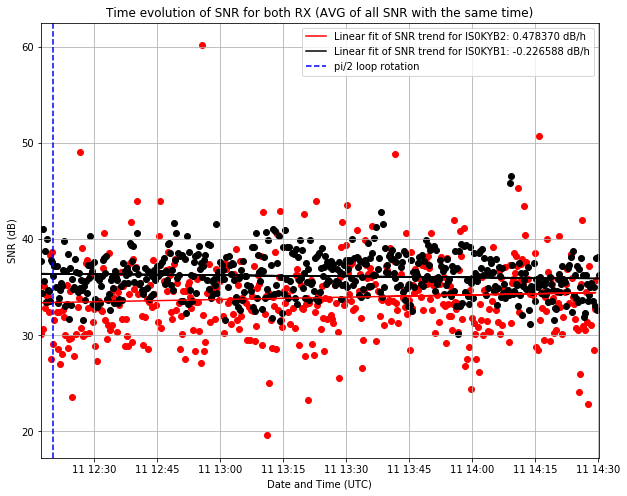

In [26]:
# SNR trend for both receivers and their linear fit with a dB/h rough estimation

plot_avg_snr(data_bycallsign_dict, timestamp_start, timestamp_stop, reporter_list, regularize=False)

In [27]:
# compute the common parts (wrt reporters) of timeseries (return timestamps for both reporters)

common_ts_bycall = data_by_callsign_common(data_bycallsign_dict, reporter_list)

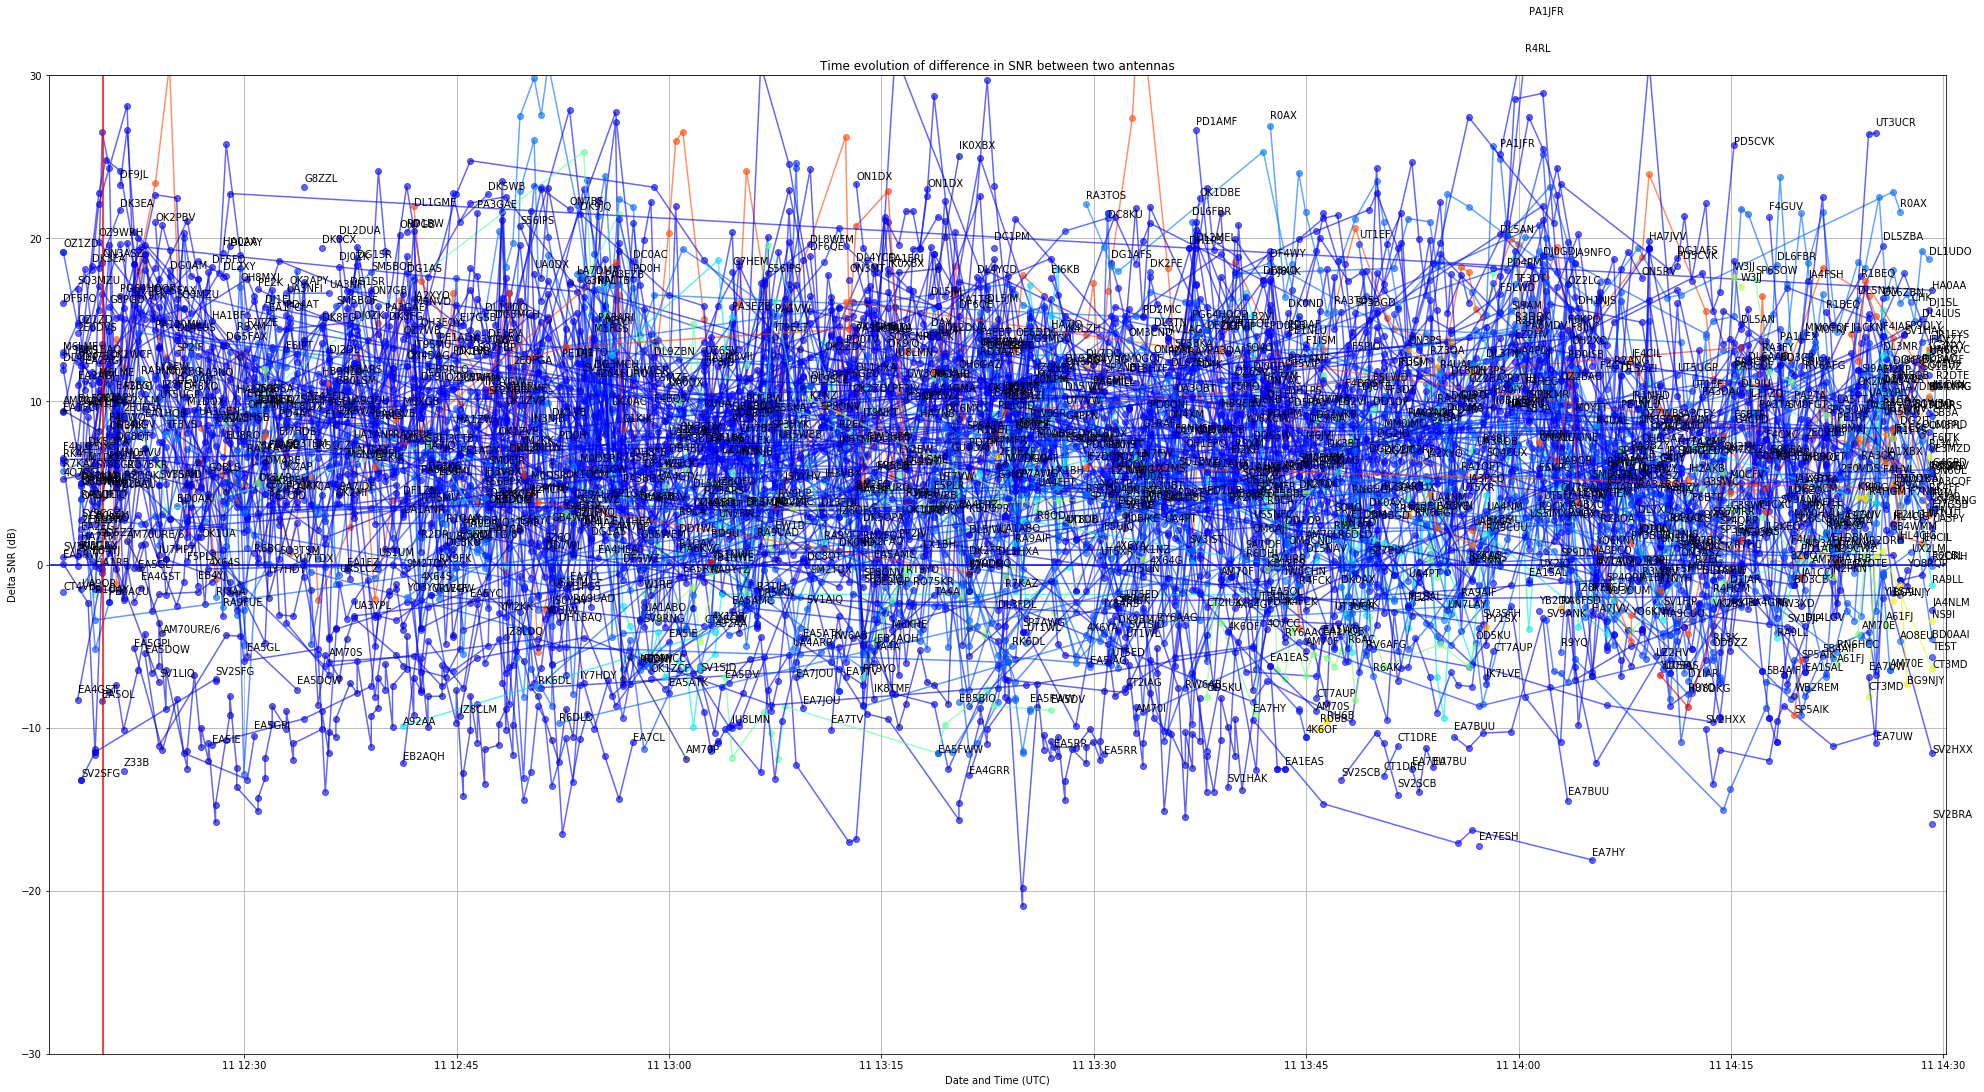

In [28]:
# create a dictionary of sorted DELTA SNR timeseries with [call] as key

deltasnr_dict = get_deltasnr_bycall(callsign_sorted_byspots, data_bycallsign_dict, timestamp_start, timestamp_stop, antenna_rotation_time, reporter_list, common_ts_bycall, rx_offset, topn=-1, plot_flag=True, country=False)

(-10, 370)

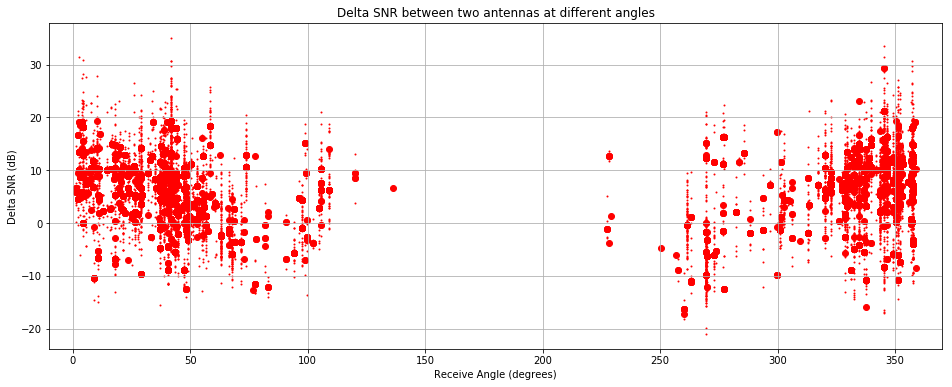

In [29]:
# Scatter plot of the difference in dB between the two antennas

plt.figure(figsize=(16,6))
for call in deltasnr_dict:
    deltasnr_list = deltasnr_dict[call]
    #print (call, coord_dict[call])
    if call in coord_dict:
        az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] for el in deltasnr_list[0]]
        deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0])]

        #az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] for el in deltasnr_list[0] if el >= antenna_rotation_time]
        #az_list2 = [(haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] + angle_offset) for el in deltasnr_list[0] if el < antenna_rotation_time]
        #deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el >= antenna_rotation_time]
        #deltasnr_list2 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el < antenna_rotation_time]

        plt.scatter(az_list1, deltasnr_list1, s=1, c="r")
        plt.scatter(az_list1, [np.median(deltasnr_list1) for _ in az_list1], c="r") #, yerr=[0.0*np.var(deltasnr_list1)  for _ in az_list1], fmt='o')
        #plt.scatter(az_list2, deltasnr_list2, s=1, c="b")
        #plt.scatter(az_list2, [np.median(deltasnr_list2) for _ in az_list2], c="b") #, yerr=[0.0*np.var(deltasnr_list2)  for _ in az_list2], fmt='o')
plt.grid()
plt.title("Delta SNR between two antennas at different angles")
plt.xlabel("Receive Angle (degrees)")
plt.ylabel("Delta SNR (dB)")
plt.xlim(-10,370)

/usr/lib/python3/dist-packages/matplotlib/projections/polar.py:162: RuntimeWarning: invalid value encountered in less
  theta = np.where(y < 0, 2 * np.pi - theta, theta)


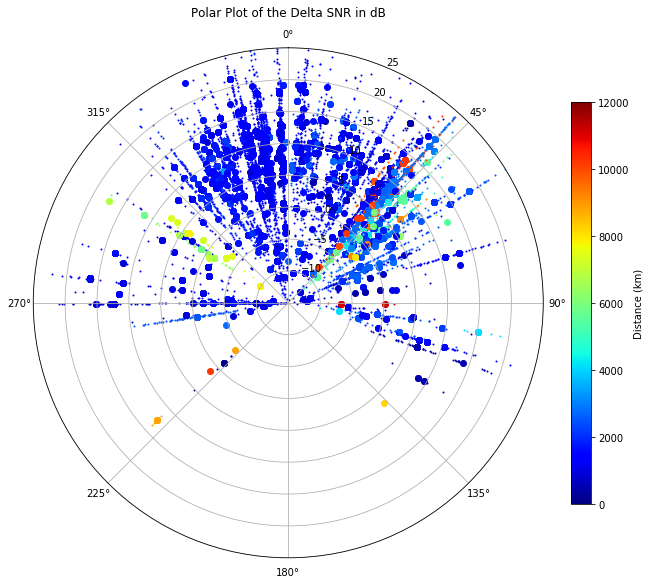

In [30]:
# Polar scatter plot of the difference in dB between the two antennas

max_dist = 12000
cmap = plt.get_cmap('jet',max_dist)

az_complete_list = []
deltasnr_complete_list = []
deltasnr_median_list = []
distance_complete_list = []
distance_list = []

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
for call in deltasnr_dict:
    if call not in coord_dict:
        continue
    hav_ = haversine(*loc2coords(reporter_loc), *coord_dict[call] )
    #cdist = data_bycallsign_dict[call][reporter_list[0]][0][-1]
    cdist = hav_[0]
    distance_list.append([int(cdist) for _ in deltasnr_dict[call]])
    deltasnr_list = deltasnr_dict[call]
    
    az_list1 = [hav_[1]/360.*2*pi for el in deltasnr_list[0]]
    deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0])]
    
    #az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1]/360.*2*pi for el in deltasnr_list[0] if el >= antenna_rotation_time]
    #az_list2 = [(haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] + angle_offset)/360.*2*pi for el in deltasnr_list[0] if el < antenna_rotation_time]
    #deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el >= antenna_rotation_time]
    #deltasnr_list2 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el < antenna_rotation_time]
    
    if len(az_list1)>0:
        for az, deltasnr in zip(az_list1, deltasnr_list1):
            az_complete_list.append(az)
            deltasnr_complete_list.append(deltasnr)
            distance_complete_list.append(cdist)
    #if len(az_list2):
    #    for az, deltasnr in zip(az_list2, deltasnr_list2):
    #        az_complete_list.append(az)
    #        deltasnr_complete_list.append(deltasnr)
    
    angle = haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1]/360.*2*pi
    delta_snr = np.median(deltasnr_list1)
    #delta_snr = np.mean(deltasnr_list1)
    
    deltasnr_median_list.append((angle, delta_snr))
    plt.scatter(az_list1, deltasnr_list1, s=1, color=cmap(int(cdist)))
    plt.scatter(az_list1, [np.median(deltasnr_list1) for _ in az_list1], color=cmap(int(cdist))) #, yerr=[0.0*np.var(deltasnr_list1)  for _ in az_list1], fmt='o')
    #plt.scatter(az_list2, deltasnr_list2, s=1, c="b")
    #plt.scatter(az_list2, [np.median(deltasnr_list2) for _ in az_list2], c="b") #, yerr=[0.0*np.var(deltasnr_list2)  for _ in az_list2], fmt='o')
ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-15,25)
plt.title("Polar Plot of the Delta SNR in dB")

norm = mpl.colors.Normalize(vmin=0,vmax=max_dist)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,fraction=0.036, pad=0.05)
cbar.set_label('Distance (km)')


31 31


/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


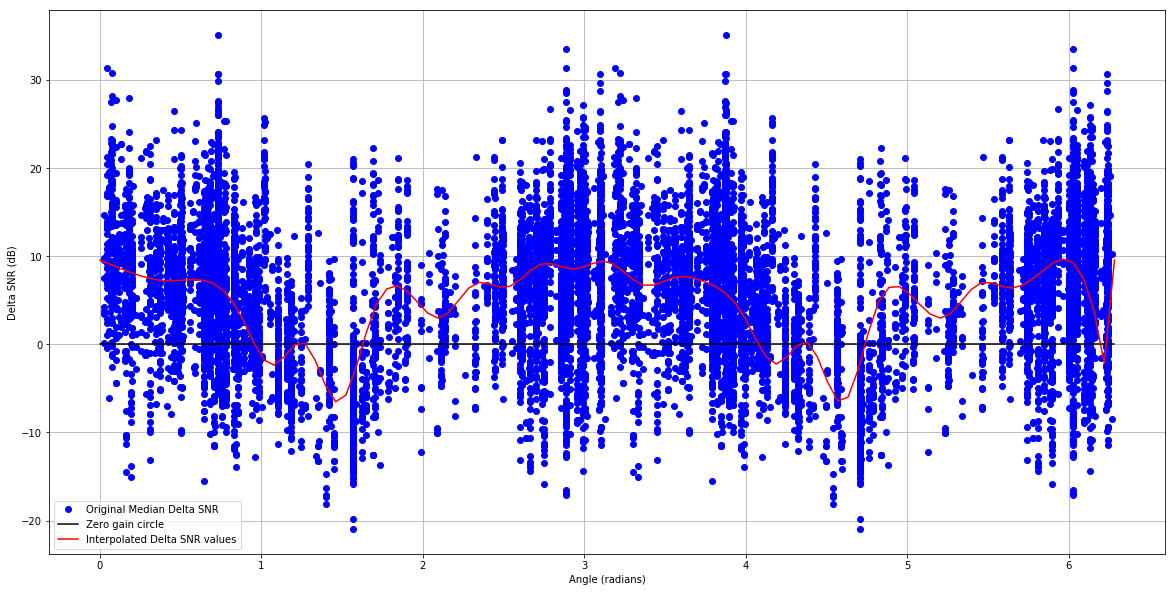

In [31]:
# Here we convert degrees to radians and perform a VERY rough 1D cubic interpolation 
# Here we make use of antenna symmetry if present

use_symmetry = True
az_rad_list = []
deltasnr_list = []
for i,(a, v) in enumerate(zip(az_complete_list, deltasnr_complete_list)):
    az_rad_list.append( a + 0.0000001*(2*rand()-1.) )
    deltasnr_list.append(v)
    if use_symmetry:
        az_rad_list.append((a+pi) %(2*pi))
        deltasnr_list.append(v)
        distance_list.append(distance_list[i])
    
angles, gains = zip(*sorted(zip(az_rad_list, deltasnr_list)))

x = np.array(angles)
y = np.array(gains)
#y_rm = running_mean(y,2) # try to smoothen the points before interpolating
x_sm, y_sm = regularize_data(x,y,0.2) # try to smoothen the points before interpolating

print(len(x_sm),len(y_sm))

f = interpolate.interp1d(x_sm, y_sm, kind="cubic", fill_value='extrapolate')
x_sm = np.linspace(0., 2*pi, 100)
y0 = np.zeros(x_sm.shape)
figure(figsize=(20,10))
plot(x, y, 'bo', label = 'Original Median Delta SNR')
plot(x_sm, y0, 'k', label = 'Zero gain circle')
plot(x_sm, f(np.mod(x_sm, 2*pi)), 'r', label = 'Interpolated Delta SNR values')
grid()
xlabel("Angle (radians)")
ylabel("Delta SNR (dB)")
#xlim(0,6.28)
#ylim(-30,30)
legend()

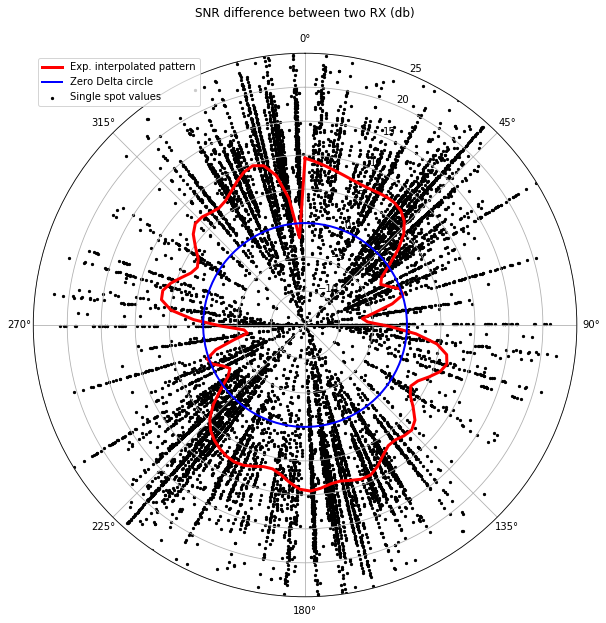

In [32]:
# Now let's finally plot the polar graph with the real SNR deltas and their interpolation
# Moreover, we plot the angular distance distribution of the spots

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
c = ax.plot(x_sm, f(np.mod(x_sm, 2*pi)), c='r', linewidth=3, label="Exp. interpolated pattern")
c0 = ax.plot(x_sm, y0, c='b', linewidth=2, label="Zero Delta circle")
c2 = ax.scatter(x, y, c='k', s=5, label="Single spot values")

ax.set_title("SNR difference between two RX (db)", va='bottom')

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-15,25)

plt.legend()
#fig = plt.figure(figsize=(15,15))
#ax = fig.add_subplot(111, projection='polar')
#ax.set_title("Distance distribution of the received stations (km)", va='bottom')


#c2 = ax.scatter(x, dist_list, c='k', s=80)

#ax.set_theta_zero_location('N', offset=0)
#ax.set_theta_direction(-1)


In [33]:
# Load CSV gain patterns produced with MMANA

fn_list = ["LazyH-16m.csv", "4cross_quads.csv"]
angle_offset_list = [340.0, 325.0] # these are the relative rotation angles of each antenna with respect to North
                                   # be sure to use POSITIVE rotations

pattern_list_list = []
for angle_offset, fn in zip(angle_offset_list, fn_list):
    header, pattern_list = read_pattern_data(fn, angle_offset)
    pattern_list = sorted(pattern_list, key=lambda x: x[1], reverse = False)
    pattern_list_list.append(pattern_list)

In [34]:
# Save to CSV the difference pattern and create a data structure for it

fn_out = "diff_pattern.csv"

diff_pattern = []
a_pattern = []
b_pattern = []

with open(fn_out, "w") as fd:
    fd.write(",".join(header)+"\n") # enable this if you want to save the difference pattern
    diff_pattern_list = []
    for row1, row2 in zip(*pattern_list_list):
        diff = "%3.1f,%3.1f,%3.2f,%3.2f,%3.2f\n"%(row1[0], row1[1], row1[2]-row2[2], row1[3]-row2[3], row1[4]-row2[4])
        fd.write(diff)
        diff_pattern.append([row1[0], row1[1], row1[4]-row2[4]])
        a_pattern.append([row1[0], row1[1], row1[4]])
        b_pattern.append([row2[0], row2[1], row2[4]])
        

/usr/lib/python3/dist-packages/matplotlib/projections/polar.py:162: RuntimeWarning: invalid value encountered in less
  theta = np.where(y < 0, 2 * np.pi - theta, theta)


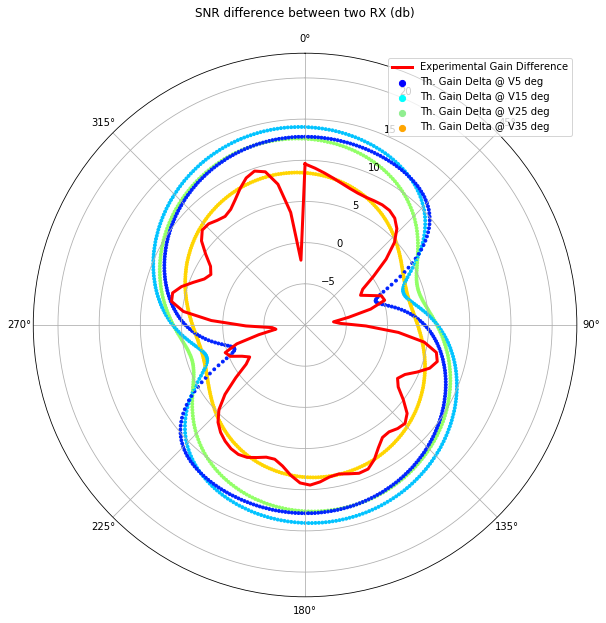

In [35]:
# Plot the Theoretical Gain Difference along with the interpolation and real data
# The model gain is plotted at several vertical angles 

markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

N_angles = 20
N_km = 12000
cmap = plt.get_cmap('jet', N_angles)
#cmap2 = plt.get_cmap('jet', N_km)

zen_min, zen_max = 0., 45 # select Zenith angle range for the theoretical pattern

norm = mpl.colors.Normalize(vmin=zen_min,vmax=zen_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


az_list = []
zen_list = []
gain_list = []
for row in diff_pattern:
    zen = 90-row[0]
    az = row[1]
    gain = row[2]
    
    if zen_min <= zen <= zen_max and not zen%10: # and zen in [ 10, 20, 25]:
        az_list.append(az/360.*2*pi)
        zen_list.append(zen/360.*2*pi)
        
        gain_list.append(gain)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
c1 = ax.scatter(az_list, gain_list, color=cmap(zen_list), s=8)
c2 = ax.scatter(-100, -100, color="blue", s=38, label="Th. Gain Delta @ V5 deg")
c3 = ax.scatter(-100, -100, color="cyan", s=38, label="Th. Gain Delta @ V15 deg")
c4 = ax.scatter(-100, -100, color="lightgreen", s=38, label="Th. Gain Delta @ V25 deg")
c4 = ax.scatter(-100, -100, color="orange", s=38, label="Th. Gain Delta @ V35 deg")

c = ax.plot(x_sm, f(np.mod(x_sm, 2*pi)), c='r', linewidth=3, label="Experimental Gain Difference")
#c1 = ax.scatter(x, y, c="k", s=40, label="Single Spot Median Gain Difference")

ax.set_title("SNR difference between two RX (db)", va='bottom')

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,23)
ax.legend()

#cbar = plt.colorbar(sm,fraction=0.036, pad=0.05)
#cbar.set_label('Vertical angle for (delta) model pattern (deg)')
